In [1]:
import os
from datetime import datetime

import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# Select latest data file
folder = '../data/'
files = [file for file in os.listdir(folder) if not file.startswith('.~lock')]
most_recent_data_file = max(files, key=lambda x: datetime.strptime(x.split('-')[0] + x.split('-')[1] + x.split('-')[2] + " " + x.split('-')[3] + ":" + x.split('-')[4] + ":" + x.split('-')[5], '%Y%m%d %H:%M:%S'))
data_file = folder + most_recent_data_file
print("Data file: {}".format(data_file))

Data file: ../data/2024-09-26-12-44-16-data-up-to-3364-m-2-k-1-interrupted.json


In [4]:
# Load data into DataFrame
with open(data_file, 'r') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)

In [5]:
# Is df[COLUMN] monotonically increasing?
print("Is df[COLUMN] monotonically increasing?\n")
print(f"df['timestamp']     {str(df['timestamp'].is_monotonic_increasing):5}. Should be False")
print(f"df['proof_score']   {str(df['proof_score'].is_monotonic_increasing):5}. Should be False.")
print(f"df['proof_size']    {str(df['proof_size'].is_monotonic_increasing):5}. Should be False.")
print(f"df['target']        {str(df['target'].is_monotonic_decreasing):5}. Should be False.")

Is df[COLUMN] monotonically increasing?

df['timestamp']     False. Should be False
df['proof_score']   False. Should be False.
df['proof_size']    False. Should be False.
df['target']        True . Should be False.


In [6]:
# Add block height (index) as column
df["height"] = df.index + 1

In [7]:
# Create datetime objects column from timestamps column
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')
df

,target,proof_size,proof_score,timestamp,height,timestamp_dt
0,2695953529101130949315647634472399133601089873...,1,1,1231006505,1,2009-01-03 18:15:05
1,2695953529101130949315647634472399133601089873...,2,2,1231469665,2,2009-01-09 02:54:25
2,2695953529101130949315647634472399133601089873...,3,3,1231469744,3,2009-01-09 02:55:44
3,2695953529101130949315647634472399133601089873...,4,4,1231470173,4,2009-01-09 03:02:53
4,2695953529101130949315647634472399133601089873...,5,5,1231470988,5,2009-01-09 03:16:28
...,...,...,...,...,...,...
3359,2695953529101130949315647634472399133601089873...,23,23,1234009664,3360,2009-02-07 12:27:44
3360,2695953529101130949315647634472399133601089873...,24,24,1234009927,3361,2009-02-07 12:32:07
3361,2695953529101130949315647634472399133601089873...,23,23,1234010382,3362,2009-02-07 12:39:42
3362,2695953529101130949315647634472399133601089873...,23,23,1234011206,3363,2009-02-07 12:53:26


In [8]:
df.dtypes

target                  object
proof_size               int64
proof_score              int64
timestamp                int64
height                   int64
timestamp_dt    datetime64[ns]
dtype: object

In [9]:
# DataFrame description
df.describe()

,proof_size,proof_score,timestamp,height,timestamp_dt
count,3364.000000,3364.000000,3.364000e+03,3364.00000,3364
mean,24.308264,24.308264,1.232830e+09,1682.50000,2009-01-24 20:40:05.736920320
min,1.000000,1.000000,1.231007e+09,1.00000,2009-01-03 18:15:05
25%,21.000000,21.000000,1.232223e+09,841.75000,2009-01-17 20:14:38
50%,24.000000,24.000000,1.232845e+09,1682.50000,2009-01-25 00:52:35.500000
75%,27.000000,27.000000,1.233432e+09,2523.25000,2009-01-31 20:03:13
max,42.000000,42.000000,1.234012e+09,3364.00000,2009-02-07 13:00:04
std,5.251434,5.251434,6.991632e+05,971.24748,NaN


/tmp/ipykernel_24298/65161511.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


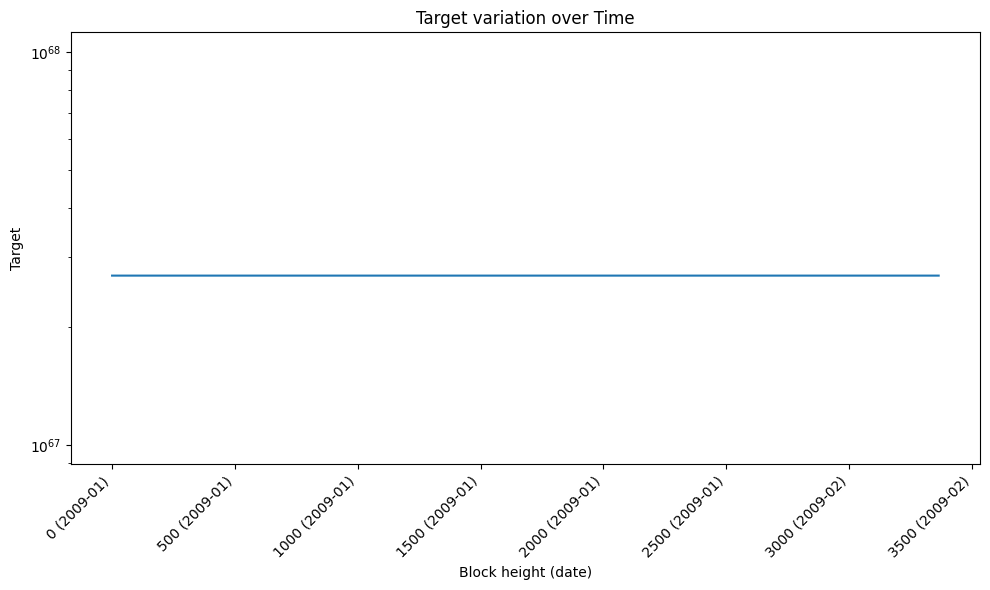

In [10]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.title('Target variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Target')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24298/3834408529.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


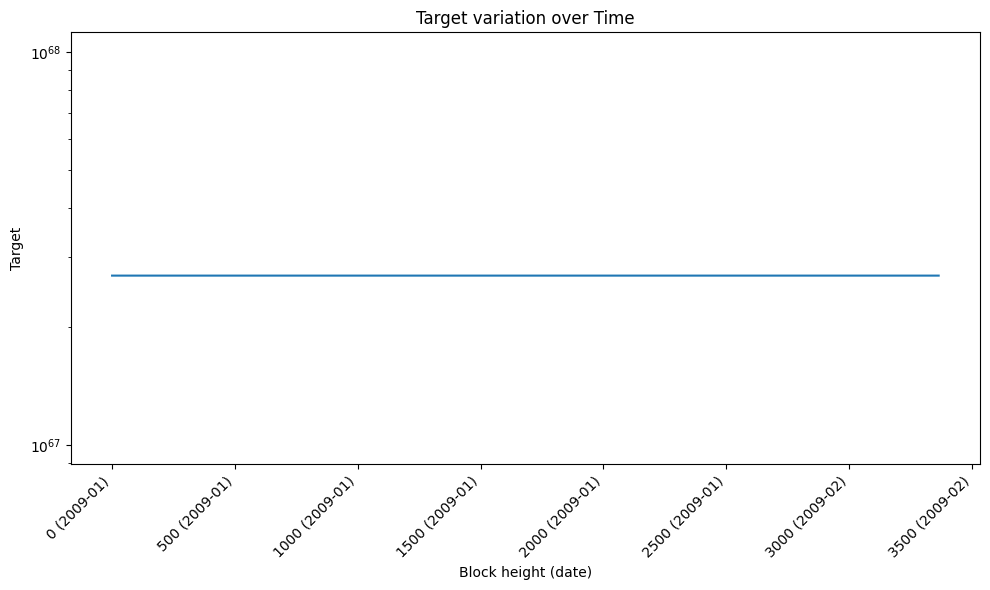

In [11]:
# Plot target over time with target increases
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.title('Target variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Target')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

# Add vertical red lines when target increases
prev_target = None
first_red_line_label = False
for i, target in enumerate(df['target']):
    if prev_target is not None and target > prev_target:
        # print(df.iloc[i]['height']) # print block heights of red lines
        plt.axvline(x=df.iloc[i]['height'], color='red', linestyle=':', linewidth=1)
        if not first_red_line_label:
            plt.text(df.iloc[i]['height'], -0.025, f"{df.iloc[i]['height']} ({df.iloc[i]['timestamp_dt'].strftime('%Y-%m')})", transform=plt.gca().get_xaxis_transform(), ha='right', va='top', rotation=45, color='red')
            first_red_line_label = True
    prev_target = target

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24298/3237839063.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


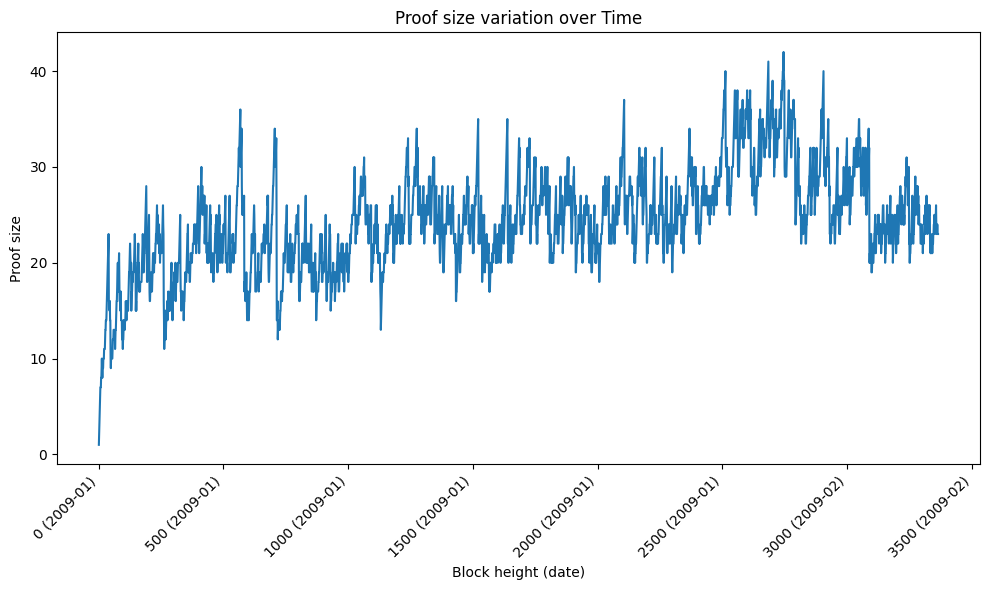

In [12]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_size'], estimator=None, sort=False)

plt.title('Proof size variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof size')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24298/2242784311.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


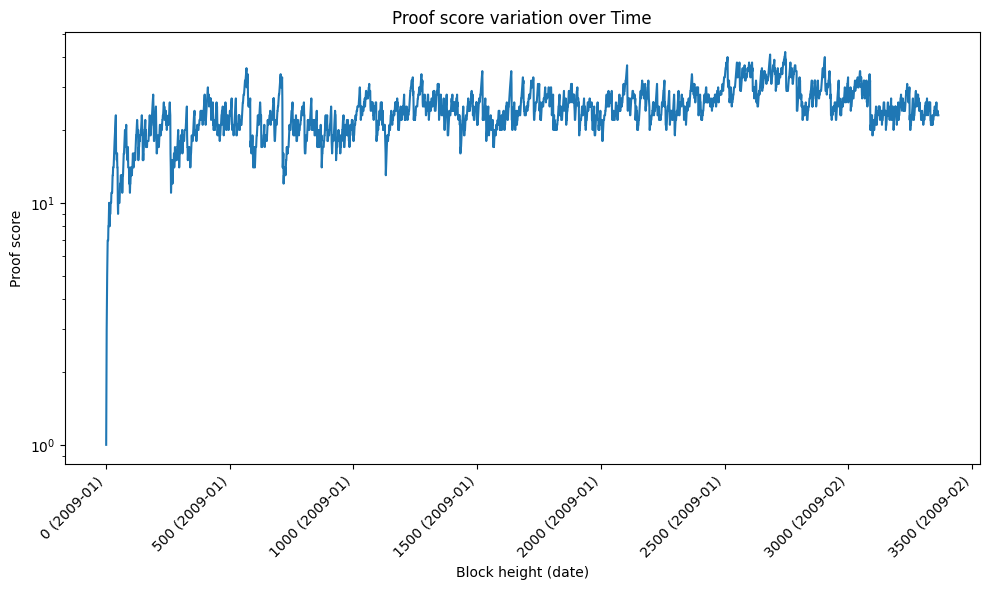

In [13]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.title('Proof score variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof score')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_24298/2061534677.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


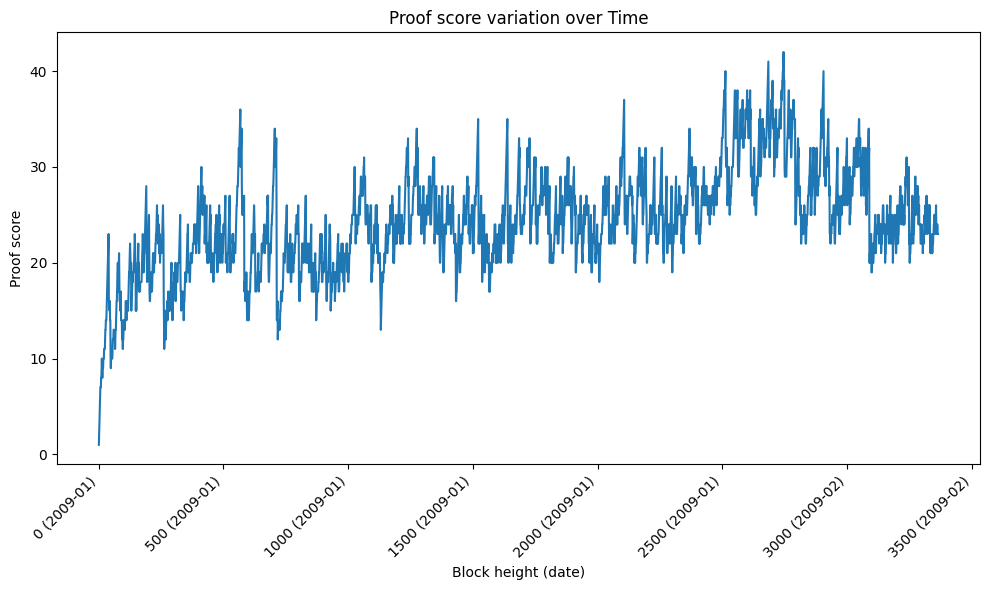

In [14]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.title('Proof score variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof score')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.grid(False)
plt.tight_layout()
plt.show()